# **Exploratory Data Analysis on Metadata**

In [1]:
from google.colab import drive, files, data_table
drive.mount('/content/drive', force_remount=True)
data_table.enable_dataframe_formatter()

%cd /content/drive/MyDrive/Capstone/
!ls

Mounted at /content/drive
/content/drive/MyDrive/Capstone
'Capstone notes.gslides'   model.png
'Capstone Proposal.gdoc'   Models
 Codes			   RSNA_Screening_Mammogram_Dataset
'First Standup.mp4'


In [2]:
!cp /content/drive/MyDrive/Capstone/Codes/Modules/data_splitter.py /content
!cp /content/drive/MyDrive/Capstone/RSNA_Screening_Mammogram_Dataset/train.csv /content

In [3]:
pip install pydicom

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
pip install python-gdcm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [5]:
pip install -U pylibjpeg[all]

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [6]:
import pandas as pd
import numpy as np
import math
import random
import scipy
from sklearn.metrics import matthews_corrcoef, davies_bouldin_score, silhouette_score, silhouette_samples
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, AgglomerativeClustering
from scipy.cluster.hierarchy import ward, dendrogram

import data_splitter as ds

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.cm as cm
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

from zipfile import ZipFile
import os
import pydicom

In [7]:
%load_ext autoreload
%autoreload 2

In [8]:
metadata = pd.read_csv('/content/train.csv')
metadata.head()

,site_id,patient_id,image_id,laterality,view,age,cancer,biopsy,invasive,BIRADS,implant,density,machine_id,difficult_negative_case
0,2,10006,462822612,L,CC,61.0,0,0,0,NaN,0,NaN,29,False
1,2,10006,1459541791,L,MLO,61.0,0,0,0,NaN,0,NaN,29,False
2,2,10006,1864590858,R,MLO,61.0,0,0,0,NaN,0,NaN,29,False
3,2,10006,1874946579,R,CC,61.0,0,0,0,NaN,0,NaN,29,False
4,2,10011,220375232,L,CC,55.0,0,0,0,0.0,0,NaN,21,True


# **Metadata**

- *site_id* - ID code for the source hospital.

- *machine_id* - An ID code for the imaging device.

- *patient_id* - ID code for the patient.

- *image_id* - ID code for the image.

- *laterality* - Whether the image is of the left or right breast.

- *view* - The orientation of the image. The default for a screening exam is to capture two views per breast.

- *age* - The patient's age in years.

- *implant* - Whether or not the patient had breast implants. Site 1 only provides breast implant information at the patient level, not at the breast level.

<br />

**Diagnosis variables** (labeled by radiologist, not to be used as model input):

- *density* - A rating for how dense the breast tissue is, with A being the least dense and D being the most dense. Extremely dense tissue can make diagnosis more difficult. Only provided for train.

- *cancer* - Whether or not the breast was positive for malignant cancer. The target value. 

- *biopsy* - Whether or not a follow-up biopsy was performed on the breast. Only provided for train.

- *invasive* - If the breast is positive for cancer, whether or not the cancer proved to be invasive. Only provided for train. (Note: Cancer that has spread beyond the layer of tissue in which it developed and is growing into surrounding, healthy tissues.)

- *BIRADS* - 0 if the breast required follow-up, 1 if the breast was rated as negative for cancer, and 2 if the breast was rated as normal. Only provided for train.

- *difficult_negative_case* - True if the case was unusually difficult. Only provided for train.

<br />

**Irrelevant:**

- *prediction_id* - The ID for the matching submission row. Multiple images will share the same prediction ID. Test only.

In [9]:
print('Total image file: ', metadata.image_id.nunique())
print('Total patient id: ', metadata.patient_id.nunique())
print('Mean image per patient: ', (metadata.image_id.nunique()/metadata.patient_id.nunique()))

Total image file:  54706
Total patient id:  11913
Mean image per patient:  4.592126248635944


In [10]:
print('Sites: ', metadata.site_id.unique())
print('Total patient_id from site 1: ', metadata[metadata['site_id']==1].patient_id.nunique())
print('Total patient_id from site 2: ', metadata[metadata['site_id']==2].patient_id.nunique())

print('Total image_id from site 1: ', metadata[metadata['site_id']==1].image_id.nunique())
print('Total image_id from site 2: ', metadata[metadata['site_id']==2].image_id.nunique())

Sites:  [2 1]
Total patient_id from site 1:  5818
Total patient_id from site 2:  6095
Total image_id from site 1:  29519
Total image_id from site 2:  25187


In [11]:
print('Total positive cases: ', len(metadata[metadata['cancer']==1]))
print('Total negative cases: ', len(metadata[metadata['cancer']==0]))
print('Class ratio: ', len(metadata[metadata['cancer']==1])/len(metadata[metadata['cancer']==0]))
# class imbalance

Total positive cases:  1158
Total negative cases:  53548
Class ratio:  0.021625457533427952


# Getting only training data

In [12]:
splitter = ds.DataSplitter(metadata, verbose=True)

Total patient_id in training set:  9530
Total patient_id in test set:  2383
Total image_id in training set:  43767
Total image_id in test set:  10939


In [13]:
train_ids = splitter.train.keys()
metadata = metadata[metadata['patient_id'].isin(train_ids)]

# **Missing values**

In [14]:
pip install missingno

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [15]:
import missingno

In [16]:
missing = metadata.isnull().sum().reset_index().rename(columns={0: 'count'})
missing['percent'] = missing['count']* 100 / len(metadata)
missing
# BIRADS column has very high proportion of missing value >> cannot be used as target variable

,index,count,percent
0,site_id,0,0.000000
1,patient_id,0,0.000000
2,image_id,0,0.000000
3,laterality,0,0.000000
4,view,0,0.000000
5,age,32,0.073114
6,cancer,0,0.000000
7,biopsy,0,0.000000
8,invasive,0,0.000000
9,BIRADS,22907,52.338520


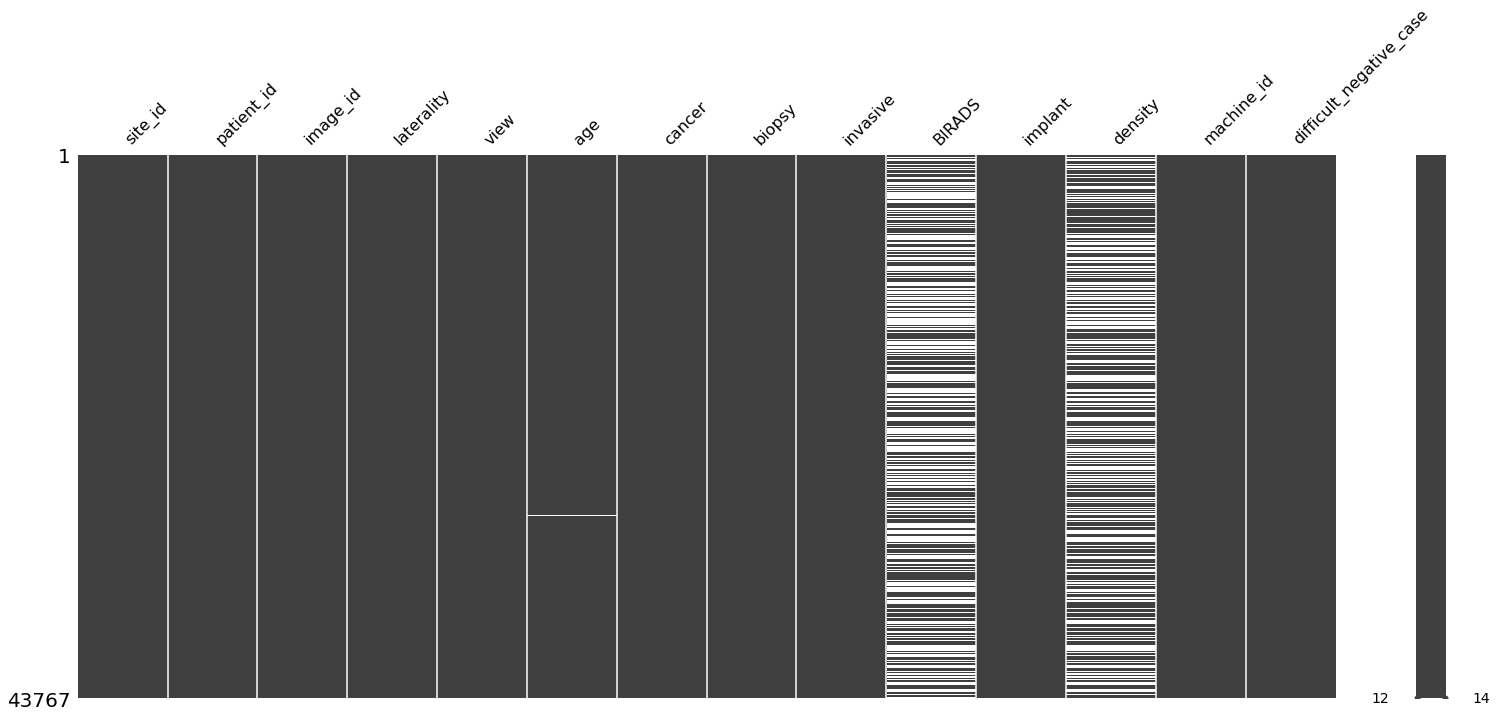

In [17]:
missingno.matrix(metadata)
plt.legend().remove()

<AxesSubplot:>

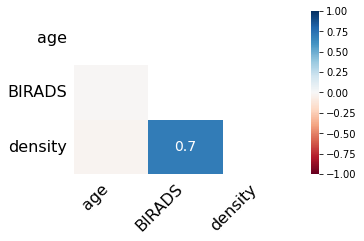

In [18]:
missingno.heatmap(metadata, figsize=(5, 3))

In [19]:
missing_by_machine = metadata.groupby(['site_id', 'machine_id'])[['age', 'BIRADS', 'density']].apply(lambda col: col.isnull().sum(axis=0)*100/len(col))
count_by_machine = metadata.groupby(['site_id', 'machine_id'])[['patient_id', 'image_id']].nunique()
missing_by_machine.merge(count_by_machine, left_index=True, right_index=True)
# seems like the majority of missing values in BIRADS and density come from site 2
# missing values in age comes from site 1 machine 49

age     BIRADS     density  patient_id  image_id
site_id machine_id                                                       
1       49          0.172108  21.314473    0.199000        3615     18593
        93          0.000000  14.231258    0.000000         322      1574
        170         0.000000  22.294654    1.043025         155       767
        190         0.000000  14.184397    0.000000          26       141
        197         0.000000  25.000000    0.000000           2        12
        210         0.000000  12.237762    0.000000         190       858
        216         0.000000  10.543989    0.000000         304      1489
2       21          0.000000  89.340855  100.000000        1636      6736
        29          0.000000  89.992453  100.000000        1618      6625
        48          0.000000  90.131956  100.000000        1663      6972

BIRADS and density columns has very high proportion of missing values. There is no density data from site 2 at all and the missing rate of BIRADS is as around 90%. Site 1 has a small portion of density values missing on 2 machine and age missing from 1 machine.

Since BIRADS has such high missing proportion, it cannot be used as target variable in predictive modelling.

In [20]:
metadata[(metadata.site_id==1)&(metadata.age.isnull())]
# age is missing at patient level so it cannot and should not be imputed

,site_id,patient_id,image_id,laterality,view,age,cancer,biopsy,invasive,BIRADS,implant,density,machine_id,difficult_negative_case
1850,1,11995,1129509810,L,CC,NaN,0,0,0,1.0,0,D,49,False
1851,1,11995,1732220752,L,MLO,NaN,0,0,0,1.0,0,D,49,False
1852,1,11995,776998051,R,MLO,NaN,0,0,0,1.0,0,D,49,False
1853,1,11995,2123005479,R,CC,NaN,0,0,0,1.0,0,D,49,False
12886,1,23752,1081106657,L,CC,NaN,0,0,0,1.0,0,C,49,False
12887,1,23752,1106722394,L,MLO,NaN,0,0,0,1.0,0,C,49,False
12888,1,23752,707585829,R,MLO,NaN,0,0,0,1.0,0,C,49,False
12889,1,23752,1982432589,R,CC,NaN,0,0,0,1.0,0,C,49,False
16230,1,27212,598973621,L,MLO,NaN,0,0,0,NaN,0,D,49,False
16231,1,27212,660603973,L,CC,NaN,0,0,0,NaN,0,D,49,False


## Distribution by Site

In [21]:
vars = np.array(['BIRADS', 'biopsy', 'cancer',
                 'density', 'difficult_negative_case', 'invasive',
                 'implant', 'laterality', 'view']).reshape(3,3)
colors = {0: '', 1:'', 2:''}
fig = make_subplots(
    rows=3, cols=3,
    subplot_titles=([var for l in vars.tolist() for var in l])
    )

for i in range(3):
  for j in range(3):
    
    df = pd.crosstab(metadata['site_id'], metadata[vars[i,j]], normalize='index').reset_index()
    df = pd.melt(df, id_vars=r'site_id', value_vars=df.columns[1:], var_name=vars[i,j])
    
    for var in df[vars[i,j]].unique():
      fig.add_trace(
        go.Bar(name=var,
               x=df[df[vars[i,j]]==var]['site_id'],
               y=df[df[vars[i,j]]==var]['value'],
               ), row=i+1, col=j+1) 

fig.update_layout(title_text='Data distribution by site', barmode='group')
fig.show()

BIRADS is about 90% missing from metadata beloging to site 2, but every data points in site 2 have BIRADS 0.
Density data is completely missing for site 2. Biopsy, cancer, invasive, and difficult negative case proportions seem about the same between site 1 and 2. Site 2 seems to not have any patients with breast implant but site 1 has a few thousounds.

Overall, the data distributions for site 1 and 2 are approximately the same.

# **Breast Imaging Reporting and Data System or BI-RADS**

A standard system radiologist or doctor used to describe mammogram findings and results.

Note: These same BI-RADS categories can also be used to describe the results of a breast ultrasound or breast MRI exam. However, the recommended next steps after these tests might be slightly different.)

<br/>

- **BIRADS 0:** Incomplete - Additional imaging evaluation and/or comparison to prior mammograms (or other imaging tests) is needed.


> This means the radiologist may have seen a possible abnormality, but it was not clear and you will need more tests, such as another mammogram with the use of spot compression (applying compression to a smaller area when doing the mammogram), magnified views, special mammogram views, and/or ultrasound. This may also suggest that the radiologist wants to compare your new mammogram with older ones to see if there have been changes in the area over time.

<br/>

- **BIRADS 1**: Negative 

> This is a normal test result. Your breasts look the same (they are symmetrical) with no masses (lumps), distorted structures, or suspicious calcifications. In this case, negative means nothing new or abnormal was found.

<br/>

- **BIRADS 2**: Benign (non-cancerous) finding

> This is also a negative test result (there’s no sign of cancer), but the radiologist chooses to describe a finding that is not cancer, such as benign calcifications, masses, or lymph nodes in the breast. This can also be used to describe changes from a prior procedure (such as a biopsy) in the breast. This ensures that others who look at the mammogram in the future will not misinterpret the benign finding as suspicious.

<br/>

- **BIRADS 3**: Probably benign finding – Follow-up in a short time frame is suggested

> A finding in this category has a very low (no more than 2%) chance of being cancer. It is not expected to change over time. But since it’s not proven to be benign, it’s helpful to be extra safe and see if the area in question does change over time.

You will likely need follow-up with repeat imaging in 6 to 12 months and regularly after that until the finding is known to be stable (usually at least 2 years). This approach helps avoid unnecessary biopsies, but if the area does change over time, it still allows for early diagnosis.

<br/>

- **BIRADS 4**: Suspicious abnormality – Biopsy should be considered

> These findings do not definitely look like cancer but could be cancer. The radiologist is concerned enough to recommend a biopsy. The findings in this category can have a wide range of suspicion levels. For this reason, this category is often divided further:
*   **4A**: Finding with a low likelihood of being cancer (more than 2% but no more than 10%)
*   **4B**: Finding with a moderate likelihood of being cancer (more than 10% but no more than 50%)
*   **4C**: Finding with a high likelihood of being cancer (more than 50% but less than 95%), but not as high as Category 5

<br/>

- **BIRADS 5**: Highly suggestive of malignancy – Appropriate action should be taken

> The findings look like cancer and have a high chance (at least 95%) of being cancer. Biopsy is very strongly recommended.

<br/>

- **BIRADS 6**: Known biopsy-proven malignancy – Appropriate action should be taken

> This category is only used for findings on a mammogram (or ultrasound or MRI) that have already been shown to be cancer by a previous biopsy. Imaging may be used in this way to see how well the cancer is responding to treatment.


Source: https://www.cancer.org/cancer/breast-cancer/screening-tests-and-early-detection/mammograms/understanding-your-mammogram-report.html


In [22]:
len(metadata[metadata.cancer==1])

913

In [23]:
metadata.BIRADS.unique()

array([nan,  0.,  1.,  2.])

It is very strange that there are only 3 categories of BIRADS present in the dataset where 913 patients are labeled as having cancer. But from the cross-tabulation, it seems that all patients who are labeled as having cancer are categorized as BIRADS 0 which means that they were callback for further diagnosis whether by diagnostic mammogram, ultrasound or MRI. From this finding, it can be assumed that radiologist/doctor normally assign BIRADS 0 if they see something suspicious in the screening mammogram. Other categories of BIRADS are assigned after confirmation from further diagnosis methods.

In [24]:
def vis_crosstab(df, row_var, col_var, normalize='all'):

  df = pd.crosstab(df[row_var], df[col_var], normalize=normalize).reset_index()
  df = pd.melt(df, id_vars=row_var, value_vars=df.columns[1:], var_name=col_var)
  
  if normalize != False:
    df['value'] = round(df['value']*100, 2)

    if normalize=='index':
      norm_var = row_var
    elif normalize=='columns':
      norm_var = col_var
      
    fig = px.bar(df, x=row_var, y='value', color=col_var, barmode = 'group', 
               color_discrete_sequence=px.colors.qualitative.Pastel,
               width=600, height=400, title='Normalize: {}'.format(norm_var))
  else:
    fig = px.bar(df, x=row_var, y='value', color=col_var, barmode = 'group', 
               color_discrete_sequence=px.colors.qualitative.Pastel,
               width=600, height=400, title='Normalize: {}'.format(normalize))
  return fig

In [25]:
vis_crosstab(metadata, 'BIRADS', 'cancer', normalize=False)

## **Breast density** 

Breast density is a measure of how much fibrous and glandular tissue (also known as fibroglandular tissue) there is in your breast, as compared to fat tissue. It isn’t related to breast size or firmness.

Younger women, especially below the age of 30, have relatively denser breasts and so sometimes it is recommended that these population should be screened for breast cancer by ultrasound.

There are 4 categories of breast density ranging from low to high:


*   A: Almost entirely fatty indicates that the breasts are almost entirely composed of fat. About 1 in 10 women has this result.
*   B: Scattered areas of fibroglandular density indicates there are some scattered areas of density, but the majority of the breast tissue is nondense. About 4 in 10 women have this result.
*   C: Heterogeneously dense indicates that there are some areas of nondense tissue, but that the majority of the breast tissue is dense. About 4 in 10 women have this result.
*   D: Extremely dense indicates that nearly all of the breast tissue is dense. About 1 in 10 women has this result.

Breast density makes it harder to detect abnormality because the fibroglandular tissue appears very opage in mammogram. Breast density is also an independent risk factor of breast cancer.

In [26]:
vis_crosstab(metadata, 'density', 'BIRADS', normalize=False)

In [27]:
vis_crosstab(metadata, 'density', 'BIRADS', normalize='index')
#round(pd.crosstab(metadata.density, metadata.BIRADS, normalize='index')*100, 2)

In [28]:
vis_crosstab(metadata, 'BIRADS', 'density', normalize='index')
#round(pd.crosstab(metadata.density, metadata.BIRADS, normalize='columns')*100, 2)

Most patients fall into breast density category B and C. Patients with breast density category A have higher rate of receiving BIRADS 1 and lower rate of BIRADS 0. Other than that, there seems to be no differences in BIRADS categories and cancer rate across different breast density levels. Breast density also does not seem to be related to difficult negative cases.

In [29]:
vis_crosstab(metadata, 'density', 'cancer', normalize='index')
#round(pd.crosstab(metadata.density, metadata.cancer, normalize='index')*100, 2)

In [30]:
vis_crosstab(metadata, 'density', 'difficult_negative_case', normalize=False)
#round(pd.crosstab(metadata.density, metadata.difficult_negative_case, normalize='all')*100, 2)

In [31]:
vis_crosstab(metadata, 'density', 'difficult_negative_case', normalize='index')
#round(pd.crosstab(metadata.density, metadata.difficult_negative_case, normalize='index')*100, 2)

In [32]:
vis_crosstab(metadata, 'BIRADS', 'difficult_negative_case', normalize=False)
#round(pd.crosstab(metadata.BIRADS, metadata.difficult_negative_case, normalize='all')*100, 2)

In [33]:
vis_crosstab(metadata, 'cancer', 'difficult_negative_case', normalize=False)
#round(pd.crosstab(metadata.cancer, metadata.difficult_negative_case, normalize='all')*100, 2)

# **Image per patient**

In [34]:
image_per_patient = metadata.groupby('patient_id')['image_id'].size().reset_index().rename(columns={'image_id': 'image_count'})
fig = px.histogram(image_per_patient, x='image_count', width=600, height=450, text_auto=True)
fig.update_traces(textposition='outside')
fig.update_layout(bargap=0.1)

Normally, there should be 4 mammogram images per patient (right_CC, right_MLO, left_CC, left_MLO) but a lot of patients have higher than that. There is no information provided by RSNA as to why, so it can be assumed that the data comes from multiple years and so patients who got mammogram annually at the same site have their images accumulated. No patient has less than 4 images which means that all of the patient have at least one complete set of images.

In [35]:
metadata.view.unique()

array(['CC', 'MLO', 'ML', 'LM', 'AT', 'LMO'], dtype=object)

In [36]:
print('ML: ', len(metadata[metadata['view']=='ML']))
print('LM: ', len(metadata[metadata['view']=='LM']))
print('LMO: ', len(metadata[metadata['view']=='LMO']))
print('AT: ', len(metadata[metadata['view']=='AT']))

ML:  8
LM:  8
LMO:  1
AT:  15


Additional views present in the dataset: ML, LM, LMO, AT

<br/>

**Lateral view** (ML and LM)

The lateral view is an additional view obtained at virtually every diagnostic evaluation. A lateral view may be obtained as a mediolateral view (ML) or lateromedial view (LM) view depending on where the imaging tube and detector are located.

Lateral views are extremely useful in determining the exact location of an abnormality in the breast. ML view is best for lesions located in the central or lateral breast. LM view is best for evaluating medial lesions.

<br/>

**Lateral-medial oblique (LMO)**

A lateral-medial oblique view is a type of supplementary mammographic view. 

The advantage of performing the lateromedial view is to depict lesions located far medio-posteriorly visible on the CC view only, or to depict palpable lesions in the inner quadrant not seen on mammography.

This view, also used for very kyphotic (exaggerated, forward rounding of the upper back) patients or in patient with a pacemaker or a port located in the upper inner quadrant, may also be helpful to demonstrate lesions located medially and not seen on the classic MLO view.

<br/>

**Axillary tail (AT)**

(guessing from the abbrev. not found 'AT' used as mammogram views during search)

An axillary view (also known as a "Cleopatra view“) is a type of supplementary mammographic view. It is an exaggerated craniocaudal view for better imaging of the lateral portion of the breast to the axillary tail. This projection is performed whenever we want to show a lesion seen only in the axillary tail on the MLO view. An optimal axillary view require to be clearly displayed the most lateral portion of the breast including the axillary tail, as well the pectoral muscle and the nipple in profile.

<br/>

These views are normally used only in diagnostic mammogram to probe specific potential abnormalities but they are present in this dataset that is supposedly containing only images from screening mammogram. My assumption is that that patients with these extra views may come to the screening with some palpable abnormalities or abnormalities found in previous screening, but if that is the case, wouldn't they be assign to ultrasound screening intead? Another possibility is that they are extra view for patients with breast implant which might obtruct doing certain views of the standard mammogram.

In [37]:
four_plus = metadata[metadata['patient_id'].isin(image_per_patient[image_per_patient['image_count']>=4].patient_id.unique())]
four_plus[['age', 'cancer', 'biopsy', 'invasive', 'BIRADS', 'implant']].describe()

,age,cancer,biopsy,invasive,BIRADS,implant
count,43735.000000,43767.000000,43767.000000,43767.000000,20860.000000,43767.000000
mean,58.559803,0.020860,0.053671,0.014417,0.769367,0.027555
std,10.060767,0.142919,0.225369,0.119205,0.587737,0.163696
min,26.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,51.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,59.000000,0.000000,0.000000,0.000000,1.000000,0.000000
75%,66.000000,0.000000,0.000000,0.000000,1.000000,0.000000
max,89.000000,1.000000,1.000000,1.000000,2.000000,1.000000


In [38]:
four = metadata[metadata['patient_id'].isin(image_per_patient[image_per_patient['image_count']==4].patient_id.unique())]
four[['age', 'cancer', 'biopsy', 'invasive', 'BIRADS', 'implant']].describe()

,age,cancer,biopsy,invasive,BIRADS,implant
count,26284.000000,26300.000000,26300.000000,26300.00000,8870.000000,26300.0
mean,58.733983,0.019392,0.039240,0.01384,0.676888,0.0
std,9.309232,0.137900,0.194168,0.11683,0.586614,0.0
min,28.000000,0.000000,0.000000,0.00000,0.000000,0.0
25%,52.000000,0.000000,0.000000,0.00000,0.000000,0.0
50%,59.000000,0.000000,0.000000,0.00000,1.000000,0.0
75%,65.000000,0.000000,0.000000,0.00000,1.000000,0.0
max,89.000000,1.000000,1.000000,1.00000,2.000000,0.0


In [39]:
four.groupby('density')['patient_id'].nunique()*100 /four[~(four['density'].isnull())]['patient_id'].nunique()

density
A     7.577175
B    43.405051
C    44.387278
D     4.630496
Name: patient_id, dtype: float64

In [40]:
four_plus.groupby('density')['patient_id'].nunique()*100 /four_plus[~(four_plus['density'].isnull())]['patient_id'].nunique()

density
A     9.685125
B    42.757872
C    42.605863
D     4.951140
Name: patient_id, dtype: float64

From a quick comparison between patients who have 4 images and higher than 4 images, there seems to be no difference in the summary statistics of all variables, except implant. There is no patient who has 4 images that has breast implant. Cancer rate among patients with breast implant is a little bit lower than patients without.

<br/>

**Additional information**

Both silicone and saline implants can make it hard for the doctor to see the breast tissue that is in line with them on the mammogram.

To help the doctor see as much breast tissue as possible, women with implants have 4 extra pictures done (2 on each breast), as well as the 4 standard pictures taken during a screening mammogram. In these extra pictures, called implant displacement (ID) views, the implant is pushed back against the chest wall and the breast is pulled forward over it and then compressed. This allows better imaging of the front part of each breast so the doctor can get a better look at the breast tissue.

Source: https://www.cancer.org/cancer/breast-cancer/screening-tests-and-early-detection/mammograms/mammograms-for-women-with-breast-implants.html

That helps explain why patients with breast implant have higher number of images. It is more probable than the extras images being from another year of annual mammogram, so it is likely that no time factor is involved.

In [41]:
print(len(metadata[metadata['laterality']=='L']), len(metadata[metadata['laterality']=='R']))

21800 21967


In [42]:
print(len(metadata[metadata['view']=='CC']), len(metadata[metadata['view']=='MLO']))

21391 22344


In [43]:
# checking whether if all of the 6575 patients who have 4 images have the right combination of a standard set of mammogram

L = metadata[metadata['laterality']=='L'].groupby('patient_id')['laterality'].size().reset_index().rename(columns={'laterality': 'L_count'})
R = metadata[metadata['laterality']=='R'].groupby('patient_id')['laterality'].size().reset_index().rename(columns={'laterality': 'R_count'})

CC = metadata[metadata['view']=='CC'].groupby('patient_id')['view'].size().reset_index().rename(columns={'view': 'CC_count'})
MLO = metadata[metadata['view']=='MLO'].groupby('patient_id')['view'].size().reset_index().rename(columns={'view': 'MLO_count'})

image_set = L.join(R.set_index('patient_id'), on='patient_id', how='outer')
image_set = image_set.join(CC.set_index('patient_id'), on='patient_id', how='outer')
image_set = image_set.join(MLO.set_index('patient_id'), on='patient_id', how='outer')
image_set.fillna(0, inplace=True)

standard_patients = image_set[(image_set['L_count']==2)&(image_set['R_count']==2)&(image_set['CC_count']==2)&(image_set['MLO_count']==2)]
len(standard_patients)

6575

In [44]:
set(four.patient_id) == set(standard_patients.patient_id)

True

In [45]:
metadata[(metadata['patient_id'].isin(standard_patients))&(metadata['implant']==1)]

,site_id,patient_id,image_id,laterality,view,age,cancer,biopsy,invasive,BIRADS,implant,density,machine_id,difficult_negative_case


In [46]:
four_plus[four_plus['implant']==0][['age', 'cancer', 'biopsy', 'invasive', 'BIRADS', 'implant']].describe()

,age,cancer,biopsy,invasive,BIRADS,implant
count,42529.000000,42561.000000,42561.000000,42561.000000,19825.000000,42561.0
mean,58.681723,0.021240,0.053641,0.014614,0.764439,0.0
std,10.045413,0.144185,0.225310,0.120004,0.591076,0.0
min,26.000000,0.000000,0.000000,0.000000,0.000000,0.0
25%,51.000000,0.000000,0.000000,0.000000,0.000000,0.0
50%,59.000000,0.000000,0.000000,0.000000,1.000000,0.0
75%,66.000000,0.000000,0.000000,0.000000,1.000000,0.0
max,89.000000,1.000000,1.000000,1.000000,2.000000,0.0


In [47]:
four_plus[four_plus['implant']==1][['age', 'cancer', 'biopsy', 'invasive', 'BIRADS', 'implant']].describe()

,age,cancer,biopsy,invasive,BIRADS,implant
count,1206.000000,1206.000000,1206.000000,1206.000000,1035.000000,1206.0
mean,54.260365,0.007463,0.054726,0.007463,0.863768,1.0
std,9.652650,0.086100,0.227540,0.086100,0.510803,0.0
min,36.000000,0.000000,0.000000,0.000000,0.000000,1.0
25%,47.000000,0.000000,0.000000,0.000000,1.000000,1.0
50%,52.000000,0.000000,0.000000,0.000000,1.000000,1.0
75%,62.000000,0.000000,0.000000,0.000000,1.000000,1.0
max,77.000000,1.000000,1.000000,1.000000,2.000000,1.0


In [48]:
# check for proportion of BIRADS score among patients with more than 4 images and do not have breast implant
four_plus[four_plus['implant']==0].groupby('BIRADS')['patient_id'].nunique()*100 / four_plus[(four_plus['implant']==0)&(~four_plus['BIRADS'].isnull())]['patient_id'].nunique()

BIRADS
0.0    47.232405
1.0    44.263196
2.0     8.504399
Name: patient_id, dtype: float64

In [49]:
# check for proportion of BIRADS score among patients with more than 4 images and breast implant
four_plus[four_plus['implant']==1].groupby('BIRADS')['patient_id'].nunique()*100 / four_plus[(four_plus['implant']==1)&(~four_plus['BIRADS'].isnull())]['patient_id'].nunique()

BIRADS
0.0    30.935252
1.0    61.870504
2.0     7.194245
Name: patient_id, dtype: float64

In [50]:
# check for proportion of difficult negative cases among patients with more than 4 images and do not have breast implant
four_plus[four_plus['implant']==0].groupby('difficult_negative_case')['patient_id'].nunique()*100 / four_plus[four_plus['implant']==0]['patient_id'].nunique()

difficult_negative_case
False    98.530508
True     25.833245
Name: patient_id, dtype: float64

In [51]:
# check for proportion of difficult negative cases among patients with more than 4 images and breast implant
four_plus[four_plus['implant']==1].groupby('difficult_negative_case')['patient_id'].nunique()*100 / four_plus[four_plus['implant']==0]['patient_id'].nunique()

difficult_negative_case
False    1.405601
True     0.436588
Name: patient_id, dtype: float64

Within population with higher than 4 images, cancer, BIRADS 0, and difficult negative case rates among patients with no breast implant are higher which suggests that patients have more than 4 images because either some abnormality was suspected or they had breast implant.

## Breast Implant

In [52]:
vis_crosstab(metadata, 'cancer', 'implant', normalize='index')
#round(pd.crosstab(metadata.implant, metadata.cancer, normalize='columns')*100, 2)

In [53]:
vis_crosstab(metadata, 'implant', 'cancer', normalize='index')
#round(pd.crosstab(metadata.implant, metadata.cancer, normalize='index')*100, 2)

In [54]:
vis_crosstab(metadata, 'implant', 'difficult_negative_case', normalize='index')
#round(pd.crosstab(metadata.implant, metadata.difficult_negative_case, normalize='index')*100, 2)

In [55]:
vis_crosstab(metadata, 'implant', 'BIRADS', normalize='index')
#round(pd.crosstab(metadata.implant, metadata.BIRADS, normalize='index')*100, 2)

In [56]:
vis_crosstab(metadata, 'implant', 'biopsy', normalize='index')

# Age

The majority of patients are above 40 years of age because the standard guideline recommend annual mammogram for women older than 40.

In [57]:
bin_size= 5
nbins = math.ceil((metadata.age.max() - metadata.age.min()) / bin_size)
fig = px.histogram(metadata, x='age', nbins=nbins, width=800, height=450, text_auto=True)
fig.update_layout(bargap=0.1)
fig.update_traces(textposition='outside')

In [58]:
print(metadata.age.max(), metadata.age.min())

89.0 26.0


In [59]:
def get_age_binned():

  age = metadata.copy()
  bins = [i for i in range(25, 90, 5)]
  labels = [str(i)+'-'+ str(j) for i, j in zip([i for i in range(25, 85, 5)], [i for i in range(30, 90, 5)])]
  age['age_bin'] = pd.cut(x = age['age'], bins = bins, labels = labels, include_lowest = True)

  return age

In [60]:
age = get_age_binned()

age = age.groupby('age_bin')['cancer'].agg(['size', 'sum']).reset_index()
age['%_cancer'] = round(age['sum']*100/age['size'], 2)
age['age_bin'] = age['age_bin'].astype('str')

fig = px.bar(age, x='age_bin', y='%_cancer', width=800, height=400, text_auto=True)
fig.update_layout(bargap=0.1)

In [61]:
age = get_age_binned()
px.imshow(round(pd.crosstab(age.age_bin, age.BIRADS, normalize='index')*100, 2), text_auto=True, width=400, height=400)

In [62]:
age = get_age_binned()
px.imshow(round(pd.crosstab(age.age_bin, age.density, normalize='index')*100, 2), text_auto=True, width=400, height=600)

In [63]:
age = get_age_binned()

age = age.groupby('age_bin')['difficult_negative_case'].agg(['size', 'sum']).reset_index()
age['%_difficult_negative_case'] = round(age['sum']*100/age['size'], 2)
age['age_bin'] = age['age_bin'].astype('str')

fig = px.bar(age, x='age_bin', y='%_difficult_negative_case', width=800, height=400, text_auto=True)
fig.update_layout(bargap=0.1)

In [64]:
age = get_age_binned()

age = age.groupby('age_bin')['biopsy'].agg(['size', 'sum']).reset_index()
age['%_biopsy'] = round(age['sum']*100/age['size'], 2)
age['age_bin'] = age['age_bin'].astype('str')

fig = px.bar(age, x='age_bin', y='%_biopsy', width=800, height=400, text_auto=True)
fig.update_layout(bargap=0.1)

Cancer rate seems to be increasing with age. The proportion of patients between 25-35 years old receiveing BIRADS 1 or no abnomality found is relatively higher compared to other age groups. From the age-density heatmap, breast density seems to decline with aging. Patients aging between 25-35 has high breast density, either categorized as C or D. Proportion between breast density categories stays relatively stable in patients 35-50 years old with about half belonging to B before starting shifting to C around 50-60, possibly due to menopause. The rate of difficult negative cases is higher among age group 30-50 which co-incides with the age group where half the patients have high breast density category C.

One thing that is strange is that age group 30-35 has the highest rate, almost double of other age groups, of receiving a follow-up biopsy even though they receive less BIRADS 0 compared to older age groups. But no patient was diagnosed with cancer. Normally, a biopsy would be done when it is highly suspicious of malignant cancer, after performing follow-up diagnostic mammogram, ultrasound, or MRI as needed.

In [65]:
# checking raw count
age = get_age_binned()
print(len(age[age['age_bin']=='30-35']), len(age[(age['age_bin']=='30-35')&(age['biopsy']==1)]))

68 10


In [66]:
age = get_age_binned()

age = age[age['biopsy']==1]
age = age.groupby('age_bin')['cancer'].agg(['size', 'sum']).reset_index()
age['%_cancer'] = round(age['sum']*100/age['size'], 2)
age['age_bin'] = age['age_bin'].astype('str')

fig = px.bar(age, x='age_bin', y='%_cancer', width=800, height=400, text_auto=True)
fig.update_layout(bargap=0.1)

In [67]:
age = get_age_binned()

age = age[age['cancer']==1]
age = age.groupby('age_bin')['biopsy'].agg(['size', 'sum']).reset_index()
age['%_biopsy'] = round(age['sum']*100/age['size'], 2)
age['age_bin'] = age['age_bin'].astype('str')

fig = px.bar(age, x='age_bin', y='%_biopsy', width=800, height=400, text_auto=True)
fig.update_layout(bargap=0.1)

In [68]:
vis_crosstab(metadata, 'BIRADS', 'biopsy', normalize='index')

In [69]:
age = get_age_binned()

age = age[age['cancer']==1]
age = age.groupby('age_bin')['invasive'].agg(['size', 'sum']).reset_index()
age['%_invasive'] = round(age['sum']*100/age['size'], 2)
age['age_bin'] = age['age_bin'].astype('str')

fig = px.bar(age, x='age_bin', y='%_invasive', width=800, height=400, text_auto=True)
fig.update_layout(bargap=0.1)

# Correlation

**Dichotomous/binary variables:**
- laterality
- view
- implant
- cancer
- biopsy
- invasive
- difficult negative case

**Categorical variables:**
- density
- BIRADS

**Continuous variable:**
- age

In [70]:
binary = metadata.copy()

# map 'view' column to binary 0, 1 >> CC=0, MLO=1
binary['view'] = np.where(binary['view']=='CC', 0, 1)

# map 'laterality' column to binary 0, 1 >> L=0, R=1
binary['laterality'] = np.where(binary['laterality']=='L', 0, 1)

# map 'density' column to 0, 1, 2, 4 >> A=0, B=1, C=2, D=3
binary['density'] = binary['density'].map({'A': 0, 'B': 1, 'C': 2, 'D': 3})


**Point-biserial correlation**

The point biserial correlation is used to measure the relationship between a binary variable, x, and a continuous variable, y. Like other correlation coefficients, this one varies between -1 and +1 with 0 implying no correlation. Correlations of -1 or +1 imply a determinative relationship.

In [71]:
# correlation between age and binary variables
binary_vars = ['laterality', 'view', 'implant', 'cancer', 'biopsy', 'invasive', 'difficult_negative_case']
corr = []

for var in binary_vars:
  df = binary.dropna(subset=['age', var])
  r, pval = scipy.stats.pointbiserialr(df[var], df['age'])
  corr.append((var, r, pval))


corr = round(pd.DataFrame(corr, columns=['variable', 'r (age)', 'p-value']).set_index('variable'), 3)
px.imshow(corr, text_auto=True, width=400, height=400)

**Phi coefficient**

In statistics, the phi coefficient (or mean square contingency coefficient and denoted by φ or rφ) is a measure of association for two binary variables. In machine learning, it is known as the Matthews correlation coefficient (MCC) and used as a measure of the quality of binary (two-class) classifications.

Phi is a chi-square based measure of association. The chi-square coefficient depends on the strength of the relationship and sample size. Phi eliminates sample size by dividing chi-square by n, the sample size, and taking the square root.

In [72]:
# correlation between binary variables 
corr = {}
for row_var in binary_vars:
  corr[row_var] = []
  for col_var in binary_vars:
    corr[row_var].append(matthews_corrcoef(binary[row_var], binary[col_var]))

corr = round(pd.DataFrame(corr, index=binary_vars), 2)
px.imshow(corr, text_auto=True, width=600, height=600)

**Cramer’s V**

Cramer's V is a measure of association between two nominal variables, giving a value between 0 and +1 (inclusive). It is based on Pearson's chi-squared statistic. φc is the intercorrelation of two discrete variables and may be used with variables having two or more levels.

In the case of a 2 × 2 contingency table Cramér's V is equal to the absolute value of Phi coefficient.

Note that as chi-squared values tend to increase with the number of cells, the greater the difference between r (rows) and c (columns), the more likely φc will tend to 1 without strong evidence of a meaningful correlation.

> φc = √(X2/N) / min(C-1, R-1)

where 
- X2: It is the Chi-square statistic
- N: It represents the total sample size
- R: It is equal to the number of rows
- C: It is equal to the number of columns

Source: https://en.wikipedia.org/wiki/Cram%C3%A9r%27s_V

In [73]:
# https://www.geeksforgeeks.org/how-to-calculate-cramers-v-in-python/

def get_cramer_v(var1, var2):

  df = metadata.dropna(subset=[var1, var2])
  crosstab = pd.crosstab(df[var1], df[var2])

  X2 = scipy.stats.chi2_contingency(crosstab, correction=False)[0]
  N = np.sum(crosstab.to_numpy()) # sample size
  min_dim = min(crosstab.shape)-1 # min(column - 1, row - 1)
    
  # Calculate Cramer's V
  return np.sqrt((X2/N) / min_dim)

In [74]:
# correlation between binary and categorical variables 
corr = {}
for row_var in ['BIRADS', 'density']:
  corr[row_var] = []
  for col_var in binary_vars:
    corr[row_var].append(get_cramer_v(row_var, col_var))

corr = round(pd.DataFrame(corr, index=binary_vars), 2)
px.imshow(corr, text_auto=True, width=400, height=400)

In [75]:
binary[['BIRADS', 'density']].corrwith(binary['age'], method='kendall').reset_index().rename(columns={0: 'age'})

,index,age
0,BIRADS,0.036705
1,density,-0.208197


# Clustering

In [76]:
feature_cols = ['age', 'laterality', 'view', 'implant', 'cancer', 'biopsy', 'invasive', 'difficult_negative_case', 'BIRADS', 'density']
features = binary[feature_cols].dropna()
features_scaled = StandardScaler().fit_transform(features)

## K-means

In [77]:
#evaluating number of clusters with K-mean clustering using elbow method
    
# inertia = []
# davies_bouldin = []
# silhouette = []

# for i in range(2,20):
#     kmeans = KMeans(n_clusters=i, init='k-means++', random_state=42, n_init='auto')
#     kmeans.fit(features_scaled)
#     inertia.append(kmeans.inertia_)

#     labels = kmeans.predict(features_scaled)
#     davies_bouldin.append(davies_bouldin_score(features_scaled, labels))
#     silhouette.append(silhouette_score(features_scaled, labels))

In [78]:
#px.line(x=range(2,20), y=inertia, labels=dict(x='Number of Cluster', y='Inertia'), width=600, height=400)
# ???

![picture](https://drive.google.com/uc?export=view&id=1okCporH-NNLTROKmrjMgrSowL4JO3YBg)

In [79]:
#px.line(x=range(2,20), y=davies_bouldin, labels=dict(x='Number of Cluster', y='Davie-Bouldin Score'), width=600, height=400)
# 3 clusters

![picture](https://drive.google.com/uc?export=view&id=1BiGyDsU_mLfpws74m2NE9n7Kl2RptyEp)

In [80]:
#px.line(x=range(2,20), y=silhouette, labels=dict(x='Number of Cluster', y='Silhouette Score'), width=600, height=400)
# 3 clusters?

![picture](https://drive.google.com/uc?export=view&id=1_ueMFrfm77R7SWPpnPdAy_ncLFZUiqcG)

In [81]:
kmeans = KMeans(n_clusters=3, init='k-means++', random_state=42, n_init='auto')
kmeans.fit(features_scaled)

KMeans(n_clusters=3, n_init='auto', random_state=42)

In [82]:
kmeans_df = metadata.dropna()
kmeans_df['cluster'] = kmeans.labels_
kmeans_df.head()

<ipython-input-82-3b37ed611b95>:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,site_id,patient_id,image_id,laterality,view,age,cancer,biopsy,invasive,BIRADS,implant,density,machine_id,difficult_negative_case,cluster
12,1,10038,1967300488,L,MLO,60.0,0,0,0,1.0,0,C,216,False,1
13,1,10038,2142944869,L,CC,60.0,0,0,0,1.0,0,C,216,False,1
14,1,10038,850559196,R,MLO,60.0,0,0,0,1.0,0,C,216,False,1
15,1,10038,1350492010,R,CC,60.0,0,0,0,1.0,0,C,216,False,1
16,1,10042,102733848,L,CC,51.0,0,0,0,1.0,0,C,93,False,1


In [83]:
def plot_silhouette_sample(scaled_arr, model, n_clusters):

  # Create a subplot with 1 row and 1 columns
  fig, ax = plt.subplots(1, 1, figsize=(5, 7))

  # The silhouette coefficient can range from -1, 1 but in this example all lie within [-0.1, 1]
  ax.set_xlim([-0.1, 0.6])

  # The (n_clusters+1)*10 is for inserting blank space between silhouette
  # plots of individual clusters, to demarcate them clearly.
  ax.set_ylim([0, len(scaled_arr) + (n_clusters + 1) * 10])

  # Initialize the clusterer with n_clusters value and a random generator
  # seed of 10 for reproducibility.

  if model == 'kmean':
      kmean = KMeans(n_clusters=n_clusters, init='k-means++', random_state=42, n_init='auto')
      cluster_labels = kmean.fit_predict(scaled_arr)

  if model == 'agglomerative':
      agglo = AgglomerativeClustering(n_clusters=n_clusters)
      cluster_labels = agglo.fit_predict(scaled_arr)

  # The silhouette_score gives the average value for all the samples.
  # This gives a perspective into the density and separation of the formed
  # clusters
  silhouette_avg = silhouette_score(scaled_arr, cluster_labels)
  print("For n_clusters =", n_clusters,
      "The average silhouette_score is :", silhouette_avg)

  # Compute the silhouette scores for each sample
  sample_silhouette_values = silhouette_samples(scaled_arr, cluster_labels)

  y_lower = 10
  for i in range(n_clusters):
      # Aggregate the silhouette scores for samples belonging to
      # cluster i, and sort them
      ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

      ith_cluster_silhouette_values.sort()

      size_cluster_i = ith_cluster_silhouette_values.shape[0]
      y_upper = y_lower + size_cluster_i

      color = cm.nipy_spectral(float(i) / n_clusters)
      ax.fill_betweenx(
          np.arange(y_lower, y_upper),
          0,
          ith_cluster_silhouette_values,
          facecolor=color,
          edgecolor=color,
          alpha=0.7,
      )

      # Label the silhouette plots with their cluster numbers at the middle
      ax.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

      # Compute the new y_lower for next plot
      y_lower = y_upper + 10  # 10 for the 0 samples

  ax.set_title("The silhouette plot for the various clusters.")
  ax.set_xlabel("The silhouette coefficient values")
  ax.set_ylabel("Cluster label")

  # The vertical line for average silhouette score of all the values
  ax.axvline(x=silhouette_avg, color="red", linestyle="--")

  ax.set_yticks([])  # Clear the yaxis labels / ticks
  ax.set_xticks([-0.1, 0, 0.1, 0.2, 0.3, 0.4, 0.5])

For n_clusters = 3 The average silhouette_score is : 0.34928231664388376


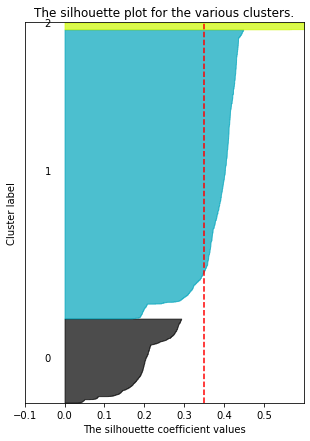

In [84]:
plot_silhouette_sample(features_scaled, model='kmean', n_clusters=3)

In [85]:
kmeans_df.groupby('cluster')['patient_id'].nunique()

cluster
0    1503
1    2966
2     129
Name: patient_id, dtype: int64

### Data distributions by cluster

In [86]:
vars = np.array(['BIRADS', 'biopsy', 'cancer',
                 'density', 'difficult_negative_case', 'invasive',
                 'implant', 'laterality', 'view']).reshape(3,3)

fig = make_subplots(
    rows=3, cols=3,
    subplot_titles=([var for l in vars.tolist() for var in l])
    )

for i in range(3):
  for j in range(3):
    
    df = pd.crosstab(kmeans_df['cluster'], kmeans_df[vars[i,j]], normalize='index').reset_index()
    df = pd.melt(df, id_vars=r'cluster', value_vars=df.columns[1:], var_name=vars[i,j])
    
    for var in df[vars[i,j]].unique():
      fig.add_trace(
        go.Bar(name=var,
               x=df[df[vars[i,j]]==var]['cluster'],
               y=df[df[vars[i,j]]==var]['value'],
               ), row=i+1, col=j+1) 

fig.update_layout(title_text='Kmeans clustering results', barmode='group')
fig.show()

Because rows with missing data were dropped, only data from site 1 is used in clustering (density is completely missing for site 2). But the distributions of other variables are about the same for site 1 and 2 so the clustering results using site 1 data are likely generalizable to site 2. 

Implant and density distributions seem constant across clusters. The clusters are likely be divided mainly by cancer and difficult negative case. All patients in cluster 2 (129) are diagnosed with invasive cancer. Most patients in cluster 0 (1,503) are difficult negative cases with a small proportion diagnosed with cancer but not invasive. Patients in both cluster 0 and 2 are classified as BIRADS 0 which means they were called back for further diagnosis. Cluster 1 (2,966) has no patient with cancer nor classified as difficult negative cases; they are labeled as neither BIRADS 1 negative or BIRADS 2 benign. 

The overall age distribution in cluster 2 is older than the other two with most above 55. Cluster 0 age groups are more even distributed than cluster 1 which is more concentrated around 40-70.

In [87]:
vis_crosstab(kmeans_df, 'cluster', 'site_id', normalize='index')
# because patients from site 2 were dropped due to missing density and BIRADS

In [88]:
fig = go.Figure()
fig.add_trace(
    go.Histogram(
        x=kmeans_df[kmeans_df['cluster']==0]['age'],
        xbins=dict(start=25, end=90, size=5)
))

fig.add_trace(
    go.Histogram(
        x=kmeans_df[kmeans_df['cluster']==1]['age'],
        xbins=dict(start=25, end=90, size=5)
))

fig.add_trace(
    go.Histogram(
        x=kmeans_df[kmeans_df['cluster']==2]['age'],
        xbins=dict(start=25, end=90, size=5)
))

#fig.update_layout(barmode='overlay')
fig.update_layout(title_text='Clusters by age groups', bargap=0.1)
fig.update_traces(opacity=0.75)
fig.show()

### Sample images by cluster

In [89]:
!pip install --upgrade --force-reinstall --no-deps kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.3/63.3 KB 2.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for kaggle: filename=kaggle-1.5.13-py3-none-any.whl size=77734 sha256=2280da57eb7c7833cc9955917dd933d15951b01bccb1dde8f9b5b3033b4d37db
  Stored in directory: /root/.cache/pip/wheels/9c/45/15/6d6d116cd2539fb8f450d64b0aee4a480e5366bb11b42ac763
Successfully built kaggle
  Attempting uninstall: kaggle
    Found existing installation: kaggle 1.5.13
    Uninstalling kaggle-1.5.13:
      Successfully uninstalled kaggle-1.5.13


In [90]:
os.environ['KAGGLE_USERNAME'] = "irinbt" # username from the json file
os.environ['KAGGLE_KEY'] = "828a846cca4f896d9aae3b558ba5d04f" # key from the json file

def unzip(file_name):

  # opening the zip file in READ mode
  with ZipFile(file_name, 'r') as zip:
      # printing all the contents of the zip file
      zip.printdir()
  
      # extracting all the files
      print('Extracting {}'.format(file_name))
      zip.extractall()
      os.remove(file_name)

def load(save_path, patient_id, image_id):
    
    os.chdir(save_path)
    if os.path.exists(str(image_id)+'.dcm'):
      print('File already exists')
    else:
      file_path = 'train_images' + '/' + str(patient_id) + '/' + str(image_id) + '.dcm'
      !kaggle competitions download -c rsna-breast-cancer-detection -f $file_path
        
    try:
      unzip(str(image_id) + '.dcm.zip')
    except:
      print('File is not zip')


def read(basepath, image_id):
  
  file_path = basepath + '/' + str(image_id) + '.dcm'
  dcm = pydicom.dcmread(file_path)
  img = dcm.pixel_array

  return img

In [91]:
random.seed(42)
kmeans_ids = {}
for cluster in kmeans_df.cluster.unique():
  kmeans_ids[cluster] = {}
  patient_ids = random.sample(kmeans_df.patient_id.unique().tolist(), k=16)
  for patient in patient_ids:
    kmeans_ids[cluster][patient] = random.sample(kmeans_df[kmeans_df['patient_id']==patient].image_id.unique().tolist(), k=1)[0]

In [92]:
for cluster in kmeans_df.cluster.unique():
  for patient_id, image_id in kmeans_ids[cluster].items():
    load('/content/drive/MyDrive/Capstone/Codes/img_for_clustering', patient_id, image_id)

File already exists
File is not zip
File already exists
File is not zip
File already exists
File is not zip
File already exists
File is not zip
File already exists
File is not zip
File already exists
File is not zip
File already exists
File is not zip
File already exists
File is not zip
File already exists
File is not zip
File already exists
File is not zip
File already exists
File is not zip
File already exists
File is not zip
File already exists
File is not zip
File already exists
File is not zip
File already exists
File is not zip
File already exists
File is not zip
File already exists
File is not zip
File already exists
File is not zip
File already exists
File is not zip
File already exists
File is not zip
File already exists
File is not zip
File already exists
File is not zip
File already exists
File is not zip
File already exists
File is not zip
File already exists
File is not zip
File already exists
File is not zip
File already exists
File is not zip
File already exists
File is 

In [93]:
def img_by_cluster(cluster_label, ids):
  img_id_arr = np.array(list(ids[cluster_label].values())).reshape(4, 4)
  fig, axes = plt.subplots(4, 4, figsize=(12, 12))
  
  for i in range(4):
    for j in range(4):
      id = img_id_arr[i,j]
      img = read('/content/drive/MyDrive/Capstone/Codes/img_for_clustering', id)
      axes[i,j].imshow(img, cmap='gray')
  
  fig.suptitle(f'Cluster {cluster_label}')
  #return fig

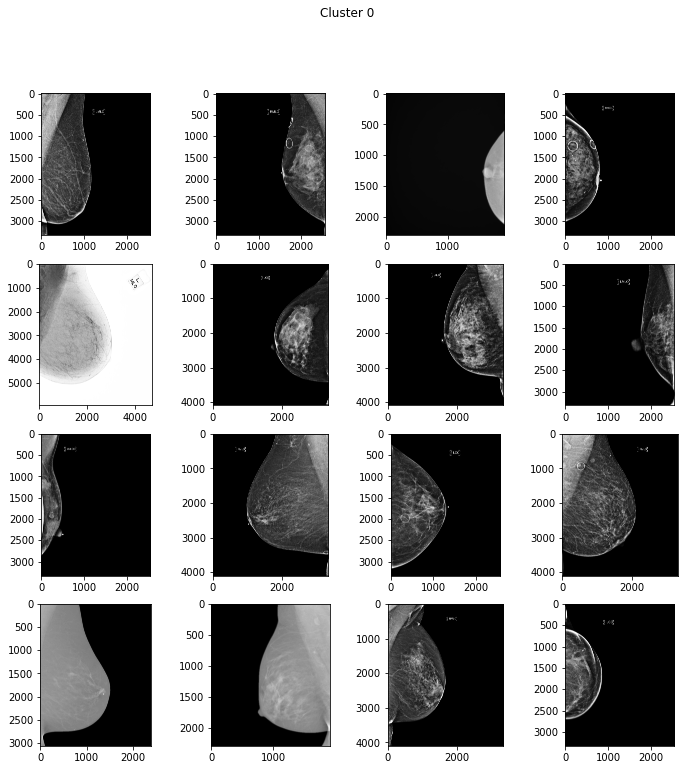

In [94]:
img_by_cluster(0, kmeans_ids)
# patients cluster 0 are mostly difficult negative cases, all BIRADS 0 requiring further diagnosis

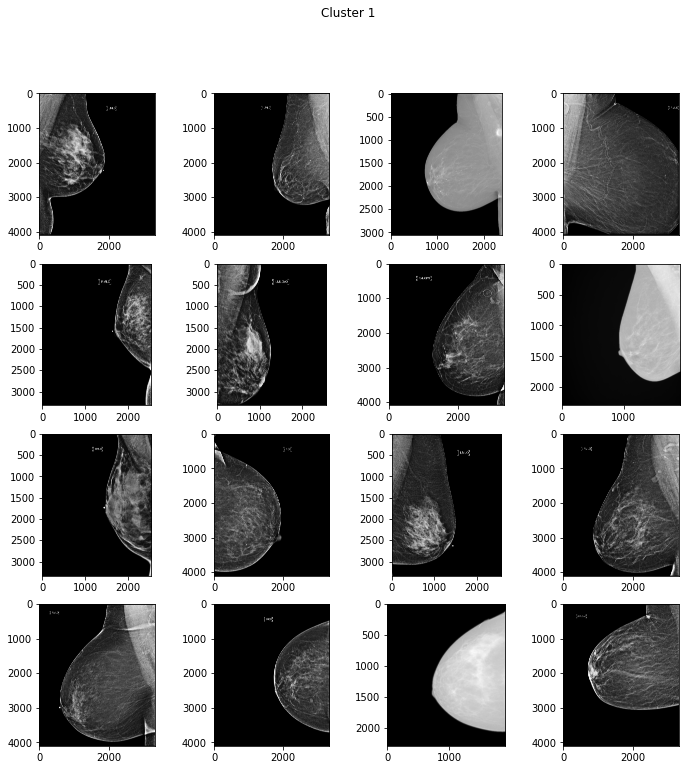

In [95]:
img_by_cluster(1, kmeans_ids)
# patients in cluster 1 are either BIRADS 1 negative or BIRADS 2 benign

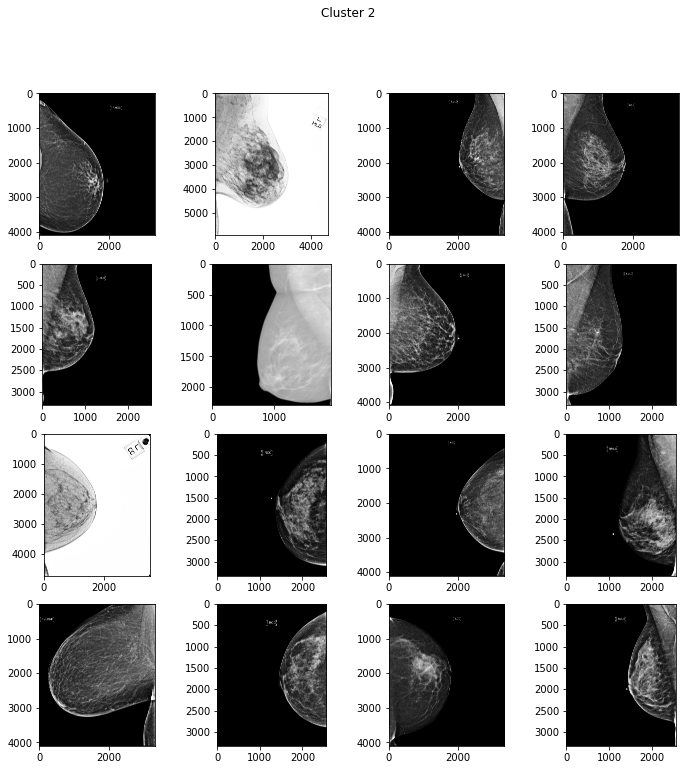

In [96]:
img_by_cluster(2, kmeans_ids)
# patients in cluster 2 all have invasive cancer proven by biopsy

## Agglomertive Clustering

In [97]:
# plt.figure(figsize=(5, 5))
# dendrogram(ward(features_scaled))
# plt.grid(axis='y')
# plt.ylabel('Distance')
# plt.show()
# 3 clusters

![picture](https://drive.google.com/uc?export=view&id=1nrnw5geESAqKCsOYfD1ibuciHxfOYNyK)

In [98]:
agglo = AgglomerativeClustering(n_clusters=3)
agglo.fit(features_scaled)

agglo_df = metadata.dropna()
agglo_df['cluster'] = agglo.labels_
agglo_df.head()

<ipython-input-98-42e1bfe31204>:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,site_id,patient_id,image_id,laterality,view,age,cancer,biopsy,invasive,BIRADS,implant,density,machine_id,difficult_negative_case,cluster
12,1,10038,1967300488,L,MLO,60.0,0,0,0,1.0,0,C,216,False,0
13,1,10038,2142944869,L,CC,60.0,0,0,0,1.0,0,C,216,False,0
14,1,10038,850559196,R,MLO,60.0,0,0,0,1.0,0,C,216,False,0
15,1,10038,1350492010,R,CC,60.0,0,0,0,1.0,0,C,216,False,0
16,1,10042,102733848,L,CC,51.0,0,0,0,1.0,0,C,93,False,0


For n_clusters = 3 The average silhouette_score is : 0.3301651854861876


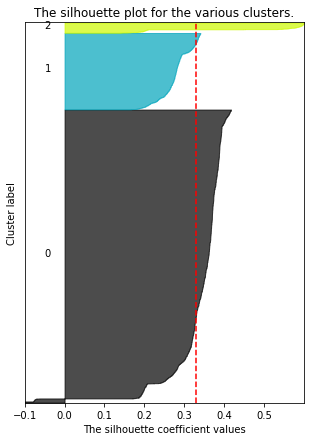

In [99]:
plot_silhouette_sample(features_scaled, model='agglomerative', n_clusters=3)

In [100]:
agglo_df.groupby('cluster')['patient_id'].nunique()

cluster
0    3007
1    1396
2     195
Name: patient_id, dtype: int64

### Data distributions by cluster

In [101]:
vars = np.array(['BIRADS', 'biopsy', 'cancer',
                 'density', 'difficult_negative_case', 'invasive',
                 'implant', 'laterality', 'view']).reshape(3,3)
colors = {0: '', 1:'', 2:''}
fig = make_subplots(
    rows=3, cols=3,
    subplot_titles=([var for l in vars.tolist() for var in l])
    )

for i in range(3):
  for j in range(3):
    
    df = pd.crosstab(agglo_df['cluster'], agglo_df[vars[i,j]], normalize='index').reset_index()
    df = pd.melt(df, id_vars=r'cluster', value_vars=df.columns[1:], var_name=vars[i,j])
    
    for var in df[vars[i,j]].unique():
      fig.add_trace(
        go.Bar(name=var,
               x=df[df[vars[i,j]]==var]['cluster'],
               y=df[df[vars[i,j]]==var]['value'],
               ), row=i+1, col=j+1) 

fig.update_layout(title_text='Agglomerative clustering results', barmode='group')
fig.show()

The most divisive variable that first divide data into two cluster seems to be cancer. Cluster 2 (195) all have cancer while cluster 0 (3,007) and 1 (1,396) has no patients with cancer.
Cluster 0 and 1 seems to be divided by difficult negative cases with cluster 1 are all difficult negative cases with corresponding BIRADS 0. But it not as clear cut as cancer since there is still some portion of difficult negative cases in cluster 0. None of cluster 0 had has biopsy and only a very small proportion received BIRADS 0.
Unlike clusters from k-menas, the distribution of implant is a little different for each cluster. Cluster 1 has no patient with breast implant while cluster 0 has the largest proportion.

Age distribution in each cluster is similar to clusters from k-means. Cluster 2 (cancer group) is older than the other two with most above 55. Cluster 1 (difficult negative cases) age groups are more even distributed than cluster 1 (negative, benign, no biopsy) which is more concentrated around 40-70.

In [102]:
fig = go.Figure()
fig.add_trace(
    go.Histogram(
        x=agglo_df[agglo_df['cluster']==0]['age'],
        xbins=dict(start=25, end=90, size=5)
))

fig.add_trace(
    go.Histogram(
        x=agglo_df[agglo_df['cluster']==1]['age'],
        xbins=dict(start=25, end=90, size=5)
))

fig.add_trace(
    go.Histogram(
        x=agglo_df[agglo_df['cluster']==2]['age'],
        xbins=dict(start=25, end=90, size=5)
))

#fig.update_layout(barmode='overlay')
fig.update_layout(bargap=0.1)
fig.update_traces(opacity=0.75)
fig.show()

### Sample images by cluster

In [103]:
agglo_ids = {}
for cluster in agglo_df.cluster.unique():
  agglo_ids[cluster] = {}
  patient_ids = random.sample(agglo_df.patient_id.unique().tolist(), k=16)
  for patient in patient_ids:
    agglo_ids[cluster][patient] = random.sample(agglo_df[agglo_df['patient_id']==patient].image_id.unique().tolist(), k=1)[0]

In [104]:
for cluster in agglo_df.cluster.unique():
  for patient_id, image_id in agglo_ids[cluster].items():
    load('/content/drive/MyDrive/Capstone/Codes/img_for_clustering', patient_id, image_id)

File already exists
File is not zip
File already exists
File is not zip
File already exists
File is not zip
File already exists
File is not zip
File already exists
File is not zip
File already exists
File is not zip
File already exists
File is not zip
File already exists
File is not zip
File already exists
File is not zip
File already exists
File is not zip
File already exists
File is not zip
File already exists
File is not zip
File already exists
File is not zip
File already exists
File is not zip
File already exists
File is not zip
File already exists
File is not zip
File already exists
File is not zip
File already exists
File is not zip
File already exists
File is not zip
File already exists
File is not zip
File already exists
File is not zip
File already exists
File is not zip
File already exists
File is not zip
File already exists
File is not zip
File already exists
File is not zip
File already exists
File is not zip
File already exists
File is not zip
File already exists
File is 

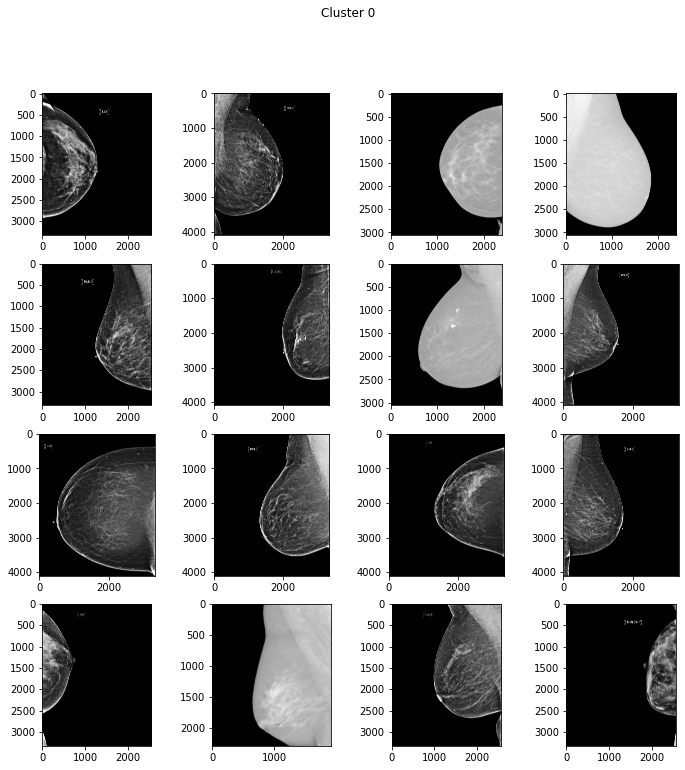

In [105]:
img_by_cluster(0, agglo_ids)
# no cancer, no biopsy, no implant, mostly BIRADS 1 negative, BIRADS 2 benign, and not difficult negatvie cases

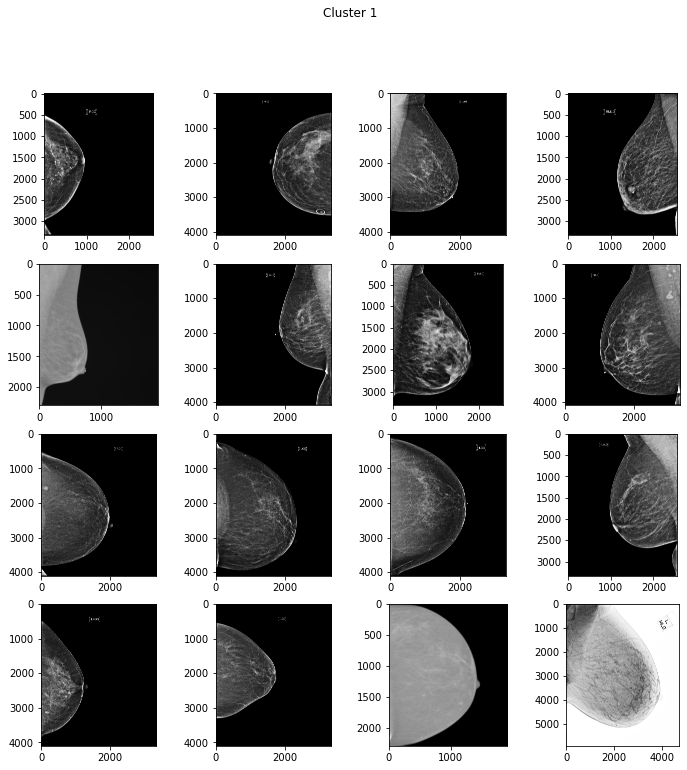

In [106]:
img_by_cluster(1, agglo_ids)
# no cancer, all difficult negative cases and BIRADS 0, 65% had biopsy

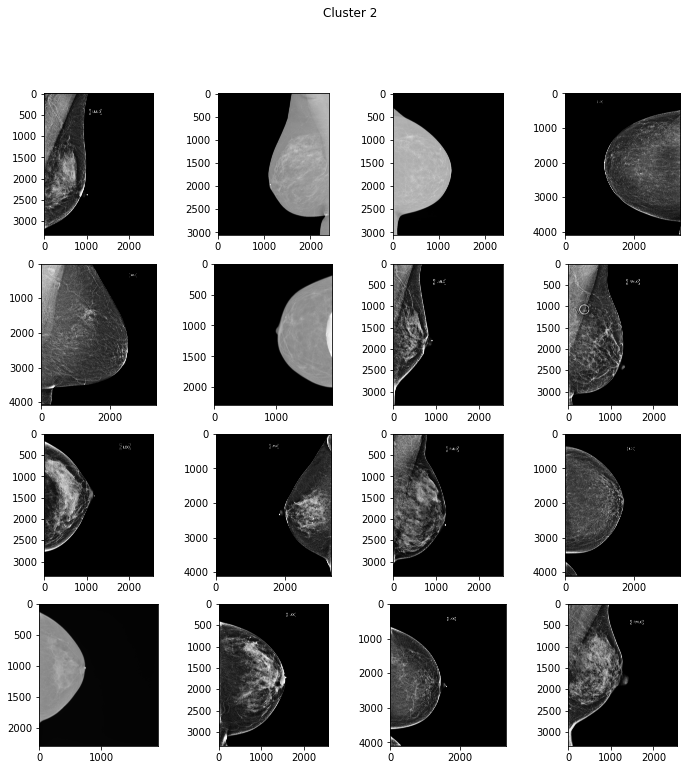

In [107]:
img_by_cluster(2, agglo_ids)
# all have biopsy-proven cancer, about 60% are invasive

## Discussion

Overall, the clusters from k-means and agglomerative clustering are quite consistent with slightly differenct emphasis on the key divisive variable (kmeans: invasive, agglomerative: cancer), and the mammogram images are very hard to distinguish between clusters by untrained eyes.

From the clustering results, density distributions are very similar across clusters, so excluding density from clustering may not affect the results much but it will enable including data from site 2 in the analysis (density is 100% missing for site 2). BIRADS also prevents incorporating site 2 data in the clustering analysis. It is reasonable enough to drop BIRADS since it has very high correlation (0.94) with difficulte negative case.

If the clustering results are consistent even excluding BIRADS and density and including data from site 2, the cluster label has some potential to be used as target variable in prediction since the clusters seem to separate cases with cancer, difficult negative cases and negative/benign cases.

# Clustering without BIRADS and density

We have tried including all variables except BIRADS, density, patient_id, image_id, site_id, and machine_id but the clustering results suggest 9 clusters. With 9 clusters, the data distributions suggest that the cluster separation does not capture any meaningful pattern. Some clusters are divides based on view and laterality which seem arbitrary, so we decided to also exclude view and laterality from performing clustering.

In [108]:
feature_cols = ['age', 'implant', 'cancer', 'biopsy', 'invasive', 'difficult_negative_case']
features = binary[feature_cols].dropna()
features_scaled = StandardScaler().fit_transform(features)

## K-means

In [109]:
#evaluating number of clusters with K-mean clustering using elbow method
    
inertia = []
davies_bouldin = []
silhouette = []

for i in range(2,20):
    kmeans = KMeans(n_clusters=i, init='k-means++', random_state=42, n_init='auto')
    kmeans.fit(features_scaled)
    inertia.append(kmeans.inertia_)

    labels = kmeans.predict(features_scaled)
    davies_bouldin.append(davies_bouldin_score(features_scaled, labels))
    silhouette.append(silhouette_score(features_scaled, labels))

In [110]:
px.line(x=range(2,20), y=inertia, labels=dict(x='Number of Cluster', y='Inertia'), width=600, height=400)
# 7 clusters

In [111]:
px.line(x=range(2,20), y=davies_bouldin, labels=dict(x='Number of Cluster', y='Davie-Bouldin Score'), width=600, height=400)
# 7 clusters

In [112]:
px.line(x=range(2,20), y=silhouette, labels=dict(x='Number of Cluster', y='Silhouette Score'), width=600, height=400)
# 7 clusters

In [113]:
kmeans = KMeans(n_clusters=7, init='k-means++', random_state=42, n_init='auto')
kmeans.fit(features_scaled)

KMeans(n_clusters=7, n_init='auto', random_state=42)

For n_clusters = 7 The average silhouette_score is : 0.5910989374645446


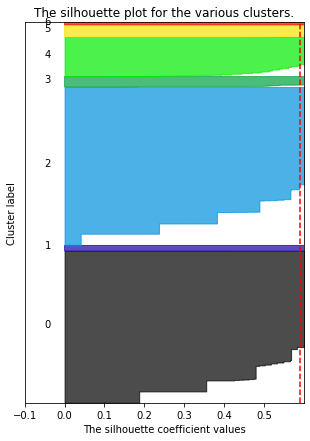

In [114]:
plot_silhouette_sample(features_scaled, model='kmean', n_clusters=7)

In [115]:
kmeans_all_df = metadata.dropna(subset=metadata.columns.difference(['BIRADS', 'density']), how='any')
kmeans_all_df['cluster'] = kmeans.labels_
kmeans_all_df.head()

<ipython-input-115-4748caf61a22>:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,site_id,patient_id,image_id,laterality,view,age,cancer,biopsy,invasive,BIRADS,implant,density,machine_id,difficult_negative_case,cluster
0,2,10006,462822612,L,CC,61.0,0,0,0,NaN,0,NaN,29,False,0
1,2,10006,1459541791,L,MLO,61.0,0,0,0,NaN,0,NaN,29,False,0
2,2,10006,1864590858,R,MLO,61.0,0,0,0,NaN,0,NaN,29,False,0
3,2,10006,1874946579,R,CC,61.0,0,0,0,NaN,0,NaN,29,False,0
4,2,10011,220375232,L,CC,55.0,0,0,0,0.0,0,NaN,21,True,4


In [116]:
kmeans_all_df.groupby('cluster')['patient_id'].nunique()

cluster
0    4399
1     270
2    4834
3     139
4    1886
5     537
6     119
Name: patient_id, dtype: int64

For n_clusters = 7 The average silhouette_score is : 0.5910989374645446


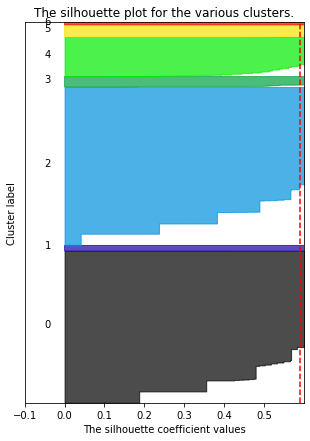

In [117]:
plot_silhouette_sample(features_scaled, model='kmean', n_clusters=7)

### Data distributions by cluster

In [118]:
vis_crosstab(kmeans_all_df, 'cluster', 'site_id', normalize='index')
# because patients from site 2 were dropped due to missing density and BIRADS

In [119]:
vars = np.array(['biopsy', 'cancer',
                 'difficult_negative_case', 'invasive',
                 'implant', 'view',
                 'laterality', 'site_id']).reshape(4,2)

fig = make_subplots(
    rows=4, cols=2,
    subplot_titles=([var for l in vars.tolist() for var in l])
    )

for i in range(4):
  for j in range(2):
    
    df = pd.crosstab(kmeans_all_df['cluster'], kmeans_all_df[vars[i,j]], normalize='index').reset_index()
    df = pd.melt(df, id_vars=r'cluster', value_vars=df.columns[1:], var_name=vars[i,j])
    
    for var in df[vars[i,j]].unique():
      fig.add_trace(
        go.Bar(name=var,
               x=df[df[vars[i,j]]==var]['cluster'],
               y=df[df[vars[i,j]]==var]['value'],
               ), row=i+1, col=j+1) 

fig.update_layout(title_text='Kmeans clustering results', barmode='group')
fig.show()

In [120]:
kmeans = KMeans(n_clusters=2, init='k-means++', random_state=42, n_init='auto')
kmeans.fit(features_scaled)

KMeans(n_clusters=2, n_init='auto', random_state=42)

For n_clusters = 2 The average silhouette_score is : 0.808959223623075


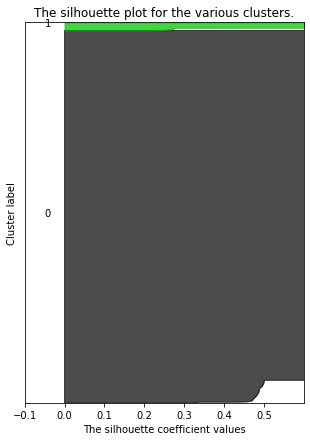

In [121]:
plot_silhouette_sample(features_scaled, model='kmean', n_clusters=2)

In [122]:
kmeans_all_df = metadata.dropna(subset=metadata.columns.difference(['BIRADS', 'density']), how='any')
kmeans_all_df['cluster'] = kmeans.labels_
kmeans_all_df.head()

<ipython-input-122-4748caf61a22>:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,site_id,patient_id,image_id,laterality,view,age,cancer,biopsy,invasive,BIRADS,implant,density,machine_id,difficult_negative_case,cluster
0,2,10006,462822612,L,CC,61.0,0,0,0,NaN,0,NaN,29,False,0
1,2,10006,1459541791,L,MLO,61.0,0,0,0,NaN,0,NaN,29,False,0
2,2,10006,1864590858,R,MLO,61.0,0,0,0,NaN,0,NaN,29,False,0
3,2,10006,1874946579,R,CC,61.0,0,0,0,NaN,0,NaN,29,False,0
4,2,10011,220375232,L,CC,55.0,0,0,0,0.0,0,NaN,21,True,0


In [123]:
kmeans_all_df.groupby('cluster')['patient_id'].nunique()

cluster
0    9519
1     389
Name: patient_id, dtype: int64

In [124]:
vars = np.array(['biopsy', 'cancer',
                 'difficult_negative_case', 'invasive',
                 'implant', 'view',
                 'laterality', 'site_id']).reshape(4,2)

fig = make_subplots(
    rows=4, cols=2,
    subplot_titles=([var for l in vars.tolist() for var in l])
    )

for i in range(4):
  for j in range(2):
    
    df = pd.crosstab(kmeans_all_df['cluster'], kmeans_all_df[vars[i,j]], normalize='index').reset_index()
    df = pd.melt(df, id_vars=r'cluster', value_vars=df.columns[1:], var_name=vars[i,j])
    
    for var in df[vars[i,j]].unique():
      fig.add_trace(
        go.Bar(name=var,
               x=df[df[vars[i,j]]==var]['cluster'],
               y=df[df[vars[i,j]]==var]['value'],
               ), row=i+1, col=j+1) 

fig.update_layout(title_text='Kmeans clustering results', barmode='group')
fig.show()

## Agglomerative Clustering

Unable to perform agglomerative clustering on the whole dataset due to limited RAM capacity, so we will try clustering on only data from site 2 to check if the results will be consistent with results from site  1 or not.

In [125]:
feature_cols = ['age', 'implant', 'cancer', 'biopsy', 'invasive', 'difficult_negative_case']
features = binary[binary['site_id']==2][feature_cols].dropna()
features_scaled = StandardScaler().fit_transform(features)

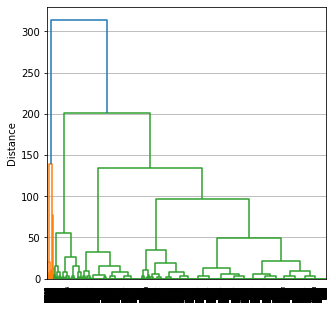

In [126]:
plt.figure(figsize=(5, 5))
dendrogram(ward(features_scaled))
plt.grid(axis='y')
plt.ylabel('Distance')
plt.show()
# 3 clusters

In [127]:
agglo = AgglomerativeClustering(n_clusters=3)
agglo.fit(features_scaled)

agglo_all_df = metadata[metadata['site_id']==2].dropna(subset=metadata.columns.difference(['BIRADS', 'density']), how='any')
agglo_all_df['cluster'] = agglo.labels_
agglo_all_df.head()

,site_id,patient_id,image_id,laterality,view,age,cancer,biopsy,invasive,BIRADS,implant,density,machine_id,difficult_negative_case,cluster
0,2,10006,462822612,L,CC,61.0,0,0,0,NaN,0,NaN,29,False,1
1,2,10006,1459541791,L,MLO,61.0,0,0,0,NaN,0,NaN,29,False,1
2,2,10006,1864590858,R,MLO,61.0,0,0,0,NaN,0,NaN,29,False,1
3,2,10006,1874946579,R,CC,61.0,0,0,0,NaN,0,NaN,29,False,1
4,2,10011,220375232,L,CC,55.0,0,0,0,0.0,0,NaN,21,True,2


For n_clusters = 3 The average silhouette_score is : 0.6847043849170482


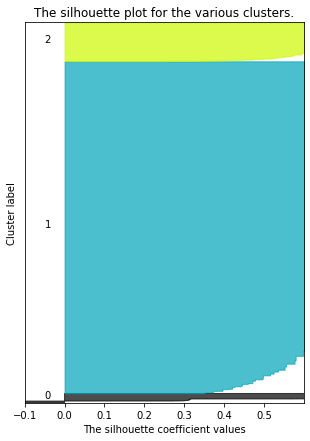

In [128]:
plot_silhouette_sample(features_scaled, model='agglomerative', n_clusters=3)

In [129]:
agglo_all_df.groupby('cluster')['patient_id'].nunique()

cluster
0     227
1    4879
2     982
Name: patient_id, dtype: int64

### Data distributions by cluster

In [130]:
vars = np.array(['biopsy', 'cancer',
                 'difficult_negative_case', 'invasive',
                 'implant', 'view']).reshape(3,2)
colors = {0: '', 1:'', 2:''}
fig = make_subplots(
    rows=3, cols=2,
    subplot_titles=([var for l in vars.tolist() for var in l])
    )

for i in range(3):
  for j in range(2):
    
    df = pd.crosstab(agglo_all_df['cluster'], agglo_all_df[vars[i,j]], normalize='index').reset_index()
    df = pd.melt(df, id_vars=r'cluster', value_vars=df.columns[1:], var_name=vars[i,j])
    
    for var in df[vars[i,j]].unique():
      fig.add_trace(
        go.Bar(name=var,
               x=df[df[vars[i,j]]==var]['cluster'],
               y=df[df[vars[i,j]]==var]['value'],
               ), row=i+1, col=j+1) 

fig.update_layout(title_text='Agglomerative clustering results', barmode='group')
fig.show()

# Discussion

The clustering results excluding BIRADS and density, and including data from site 2 seem similar from previous clustering results by prioritize different variables in dividing the main clusters. K-means suggests either 2 or 7 clusters. Both choices result in clusters that offer no new insight. The 2 clusters are divided by having cancer and not having cancer, while the 7 clusters seem to be divided by every variables used to perform the clustering e.g. first divided by invasive, then cancer, then biopsy, then difficult negative case, and implant.

As for agglomerative clustering, only data from site 2 can be used due to limited RAM capacity. The dendrogram suggest either 2 or 3 clusters. They both seems to be divided first by biopsy and then by difficult negative cases.

In summary, all of the clustering results are similar place importance on different variable (k-means site 1: invasive, agglomerative site 1: cancer, k-means site 1+2: invasive, agglomerative site 2: biopsy). Overall, clustering doesn't offer much more insight than the variables already have.

As for target variable, a peer feedback (from Dan Ehninger) on the first standup suggests that a potentially useful predictive model in practice is a model classifying the mammogram images as normal and abnormal where abnormalities include both benign and potentially malignant ones, because it can help flag the mammogram with abnormalities for practitioner to do further diagnosis. I agree with his opinion which aligns with our previous consideration to use BIRADS as target varible before finding out that almost half the data has BIRADS missing.

However, in order to classify mammogram as normal and abnormal, we need data on BIRADS 1 which indicates cases that are negative (no abnormalities, neither benign nor malignant). Cluster analysis seems to not be able to separate negative cases from all others as there is no cluster containing solely mammograms labeled as BIRADS 1 (at most there is cluster of BIRADS 1 and 2 mixture).

The bottom line is we lack the ground truth that can identify image as normal or abnormal. I think the best available variable to be used as prediction label is cancer. But by feature extraction, we might be able to extract abnormalities which can then be visualized to highlight the potential abnormality, accompanying the predicted probability of having cancer, for the radiologist/doctor to do further diagnosis. In that way, we can still deliver the normal/abnormal information to end users.